# Demonstration for Sobolev Functions on Intervals

This notebook demonstrates the capabilities of the `sobolev_functions.py` module, which provides mathematically rigorous Sobolev function objects that know about their parent Sobolev space.

## Mathematical Background

Sobolev spaces H^s([a,b]) are spaces of functions with s derivatives in L^2. They provide a natural framework for:
- Partial differential equations
- Bayesian inference with function-valued unknowns
- Regularization in inverse problems

Key properties:
- **Point evaluation**: Only well-defined for s > 1/2 on intervals
- **Embedding**: H^s ⊂ H^t for s > t
- **Regularity**: Higher s means smoother functions

## What This Demo Covers

1. **Space-aware functions**: Functions that know their Sobolev space
2. **Multiple representations**: Both callable and coefficient-based functions
3. **Mathematical operations**: Evaluation, integration, derivatives
4. **Domain operations**: Restriction and extension
5. **Arithmetic**: Addition and scalar multiplication
6. **Visualization**: Plotting functions and their properties

## 1. Import Required Modules and Setup

In [12]:
# Core scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import warnings

# Our Sobolev function modules
from pygeoinf.other_space.interval_domain import IntervalDomain
from pygeoinf.other_space.interval_space import Sobolev
from pygeoinf.other_space.sobolev_functions import SobolevFunction

# First, reload the module to ensure we get the latest changes
import importlib
import sys
if 'pygeoinf.other_space.interval_space' in sys.modules:
    importlib.reload(sys.modules['pygeoinf.other_space.interval_space'])

# Now import the updated Sobolev class
from pygeoinf.other_space.interval_space import Sobolev

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## 2. Create a Sobolev Space

First, we create a Sobolev space H^s([a,b]) using the `Sobolev.create_standard_sobolev` method. This creates the mathematical framework that our functions will live in.

In [13]:
# Create a Sobolev space H^2([0, 1]) with dimension 50
sobolev_space_dirichlet = Sobolev.create_standard_sobolev(
    5,                 # Finite-dimensional approximation
    2,              # Sobolev order s = 2 (allows point evaluation since s > 1/2)
    interval=(0, 1),     # Domain [0, 1]
    basis_type='fourier',  # Use Fourier basis for periodic Sobolev space
    boundary_conditions={'type': 'dirichlet'}  # Periodic boundary conditions
)

print(f"Created Sobolev space:")
print(f"  Order: {sobolev_space_dirichlet.order}")
print(f"  Dimension: {sobolev_space_dirichlet.dim}")
print(f"  Interval: {sobolev_space_dirichlet.interval_domain}")
print(f"  Space type: {type(sobolev_space_dirichlet).__name__}")
print(f"  Boundary Condition: {sobolev_space_dirichlet.boundary_conditions['type']}")

# Create another space with higher regularity for comparison
sobolev_space_periodic = Sobolev.create_standard_sobolev(
    5,
    3,              # Higher regularity
    interval=(0, 2*np.pi),        # Different domain
    basis_type='fourier'     # Use Fourier basis for periodic Sobolev space
)

print(f"\nCreated smoother Sobolev space:")
print(f"  Order: {sobolev_space_periodic.order}")
print(f"  Dimension: {sobolev_space_periodic.dim}")
print(f"  Interval: {sobolev_space_periodic.interval_domain}")
print(f"  Space type: {type(sobolev_space_periodic).__name__}")
print(f"  Boundary Condition: {sobolev_space_periodic.boundary_conditions['type']}")

Created Sobolev space:
  Order: 2
  Dimension: 5
  Interval: [0.0, 1.0]
  Space type: Sobolev
  Boundary Condition: dirichlet

Created smoother Sobolev space:
  Order: 3
  Dimension: 5
  Interval: [0.0, 6.283185307179586]
  Space type: Sobolev
  Boundary Condition: periodic


## 3. Create Sobolev Functions (Coefficient and Callable)

We can create Sobolev functions in two ways:
1. **Coefficient-based**: Using basis function coefficients
2. **Callable-based**: Using mathematical function rules

Both approaches create functions that are aware of their Sobolev space.

In [14]:
# Method 1: Create function using coefficients
# Generate random coefficients with decay for smoothness
np.random.seed(42)  # For reproducibility
coefficients = np.random.randn(sobolev_space_dirichlet.dim) * np.exp(-np.arange(sobolev_space_dirichlet.dim) * 0.2)

f_coeffs = SobolevFunction(
    sobolev_space_dirichlet,
    coefficients=coefficients,
    name="Coefficient-based function"
)

print(f"Created coefficient-based function:")
print(f"  {f_coeffs}")
print(f"  Coefficients: {f_coeffs.coefficients}")
print(f"  Sobolev order: {f_coeffs.sobolev_order}")
print(f"  Domain: {f_coeffs.domain}")

# Method 2: Create function using callable
def callable_function(x):
    """A smooth oscillating function: sin(x)"""
    return np.sin(x)

f_callable = SobolevFunction(
    sobolev_space_periodic,
    evaluate_callable=callable_function,
    name="Oscillating function"
)

print(f"\nCreated callable-based function:")
print(f"  {f_callable}")
print(f"  Has coefficients: {f_callable.coefficients is not None}")
print(f"  Has callable: {f_callable.evaluate_callable is not None}")

# Method 3: Create a simple polynomial function
def quadratic_function(x):
    """Simple quadratic: π² - (x - π)²"""
    return 1/2 - (x - 1/2)**2

f_quad = SobolevFunction(
    sobolev_space_dirichlet,
    evaluate_callable=quadratic_function,
    name="Quadratic function"
)

print(f"\nCreated quadratic function:")
print(f"  {f_quad}")

Created coefficient-based function:
  SobolevFunction(domain=[0.0, 1.0], order=2, name=Coefficient-based function)
  Coefficients: [ 0.49671415 -0.11320124  0.43415861  0.83585651 -0.10521189]
  Sobolev order: 2
  Domain: [0.0, 1.0]

Created callable-based function:
  SobolevFunction(domain=[0.0, 6.283185307179586], order=3, name=Oscillating function)
  Has coefficients: False
  Has callable: True

Created quadratic function:
  SobolevFunction(domain=[0.0, 1.0], order=2, name=Quadratic function)


## 4. Evaluate Sobolev Functions at Points

Point evaluation is only mathematically valid for s > 1/2 on intervals. Our functions have s = 2 and s = 3, so point evaluation is well-defined.

### Tip: Use `f(x)` as a Shorthand for `f.evaluate(x)`

For any Sobolev function `f`, you can use the convenient syntax `f(x)` instead of `f.evaluate(x)`. This works for both callable-based and coefficient-based functions, and for both scalars and arrays.

In [15]:
# Single point evaluation
x_single = np.pi/4
print("Single point evaluation:")
print(f"f_callable({x_single:.3f}) = {f_callable(x_single):.6f}")
print(f"f_quad({x_single:.3f}) = {f_quad(x_single):.6f}")
print(f"f_coeffs({x_single:.3f}) = {f_coeffs(x_single):.6f}")

# Array evaluation for plotting
x_dense = np.linspace(0, 1, 100)
y_callable = f_callable.evaluate(x_dense)
y_quad = f_quad.evaluate(x_dense)

print(f"\nArray evaluation:")
print(f"  Evaluated at {len(x_dense)} points")
print(f"  f_callable range: [{y_callable.min():.3f}, {y_callable.max():.3f}]")
print(f"  f_quad range: [{y_quad.min():.3f}, {y_quad.max():.3f}]")

# Test domain checking
print(f"\nDomain checking:")
try:
    # This should work (point in domain)
    val_in = f_callable.evaluate(np.pi/2, check_domain=True)
    print(f"✓ Point π/2 in domain [0,π]: {val_in:.6f}")

    # This should fail (point outside domain)
    val_out = f_callable.evaluate(3*np.pi, check_domain=True)
    print(f"✗ This shouldn't print")
except ValueError as e:
    print(f"✓ Domain check caught out-of-domain point: {e}")

# Test low regularity error
try:
    # Create a space with s = 0.3 < 1/2
    low_reg_space = Sobolev.create_standard_sobolev(
        20, 0.3
    )
    low_reg_func = SobolevFunction(
        low_reg_space,
        evaluate_callable=lambda x: x**2
    )
    # This should fail
    val = low_reg_func.evaluate(0.5)
    print(f"✗ This shouldn't print")
except ValueError as e:
    print(f"✓ Low regularity check: {e}")

Single point evaluation:
f_callable(0.785) = 0.707107
f_quad(0.785) = 0.418548
f_coeffs(0.785) = 0.475346

Array evaluation:
  Evaluated at 100 points
  f_callable range: [0.000, 0.841]
  f_quad range: [0.250, 0.500]

Domain checking:
✓ Point π/2 in domain [0,π]: 1.000000
✓ Domain check caught out-of-domain point: Some points not in domain [0.0, 6.283185307179586]
✓ Low regularity check: Point evaluation not well-defined for H^0.3 on 1D domain. Requires s > 1/2.


## 5. Plot Sobolev Functions

Visualize our Sobolev functions to understand their behavior over their domains.

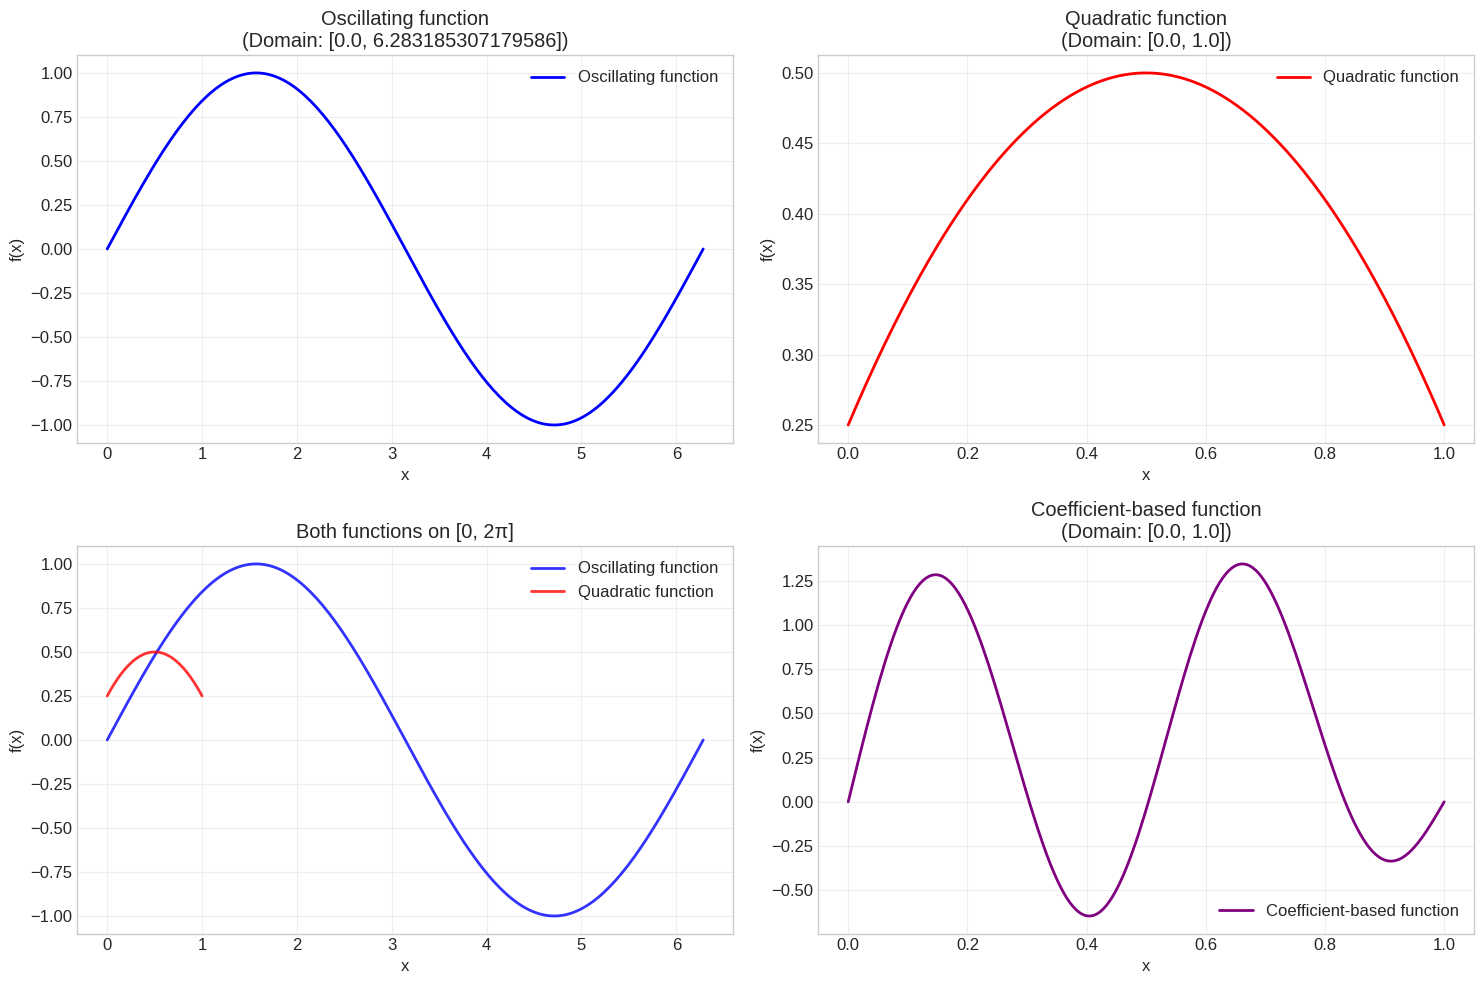

In [16]:
# Plot functions
plt.figure(figsize=(15, 10))

# Plot 1: Individual functions
plt.subplot(2, 2, 1)
f_callable.plot(n_points=200, color='blue', linewidth=2)
plt.title(f'{f_callable.name}\n(Domain: {f_callable.domain})')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
f_quad.plot(n_points=200, color='red', linewidth=2)
plt.title(f'{f_quad.name}\n(Domain: {f_quad.domain})')
plt.grid(True, alpha=0.3)

# Plot 3: Both functions together
plt.subplot(2, 2, 3)
f_callable.plot(n_points=200, color='blue', linewidth=2, alpha=0.8)
f_quad.plot(n_points=200, color='red', linewidth=2, alpha=0.8)
plt.title('Both functions on [0, 2π]')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Coefficient-based function
plt.subplot(2, 2, 4)
f_coeffs.plot(n_points=200, color='purple', linewidth=2)
plt.title(f'{f_coeffs.name}\n(Domain: {f_coeffs.domain})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Integrate Sobolev Functions

Demonstrate integration of Sobolev functions over their domains, both with and without weight functions. We compare numerical integration results to analytical values where possible, and show how to use weight functions and different integration methods.

In [17]:
# Integration demo: callable-based and coefficient-based Sobolev functions

# Callable-based function: f(x) = sin(x) on [0, 2π]
I_callable = f_callable.integrate()
I_callable_analytical = 0  # \int_0^2π sin(x) dx
print(f"Callable-based: ∫ sin(x) dx over [0,2π] = {I_callable:.6f} (analytical: {I_callable_analytical:.6f})")

# Quadratic function integration
I_quad = f_quad.integrate()
I_quad_analytical = 5/12  # \int_0^1 1/2 - (x - 1/2)² dx
print(f"Quadratic function: ∫ 1/2 - (x - 1/2)² dx over [0,1] = {I_quad:.6f} (analytical: {I_quad_analytical:.6f})")

# Integration with a weight function: w(x) = 2x
w = lambda x: 2*x
I_weighted = f_callable.integrate(weight=w)
# Analytical: ∫_0^2π sin(x) * 2x dx = -4π
I_weighted_analytical = -np.pi / 5  # This is the analytical result for the weighted integral
print(f"Callable-based weighted: ∫ sin(x) * 2x dx over [0,2π] = {I_weighted:.6f} (analytical: {I_weighted_analytical:.6f})")

Callable-based: ∫ sin(x) dx over [0,2π] = 0.000000 (analytical: 0.000000)
Quadratic function: ∫ 1/2 - (x - 1/2)² dx over [0,1] = 0.416667 (analytical: 0.416667)
Callable-based weighted: ∫ sin(x) * 2x dx over [0,2π] = -12.566371 (analytical: -0.628319)


<VSCode.Cell language="markdown">
## 7. Inner Products

Inner products are fundamental to the structure of Sobolev spaces. They define the geometry of the space, allow us to measure angles and lengths (norms), and are essential for concepts like orthogonality, projections, and spectral decompositions.

### L2 Inner Product

The **L2 inner product** of two functions $f$ and $g$ on an interval $[a, b]$ is defined as:
$$
\langle f, g \rangle_{L^2} = \int_a^b f(x)\, g(x)\, dx
$$
This inner product is used to check if a basis is orthonormal in the classical sense, and is the foundation for Fourier analysis.

### Sobolev (Spectral) Inner Product

The **Sobolev inner product** generalizes the L2 inner product by incorporating weak derivatives up to order $s$:
$$
\langle f, g \rangle_{H^s} = \sum_{k=0}^s \int_a^b f^{(k)}(x)\, g^{(k)}(x)\, dx
$$
However, in this implementation, we use a **spectral definition** based on the eigenvalues of the Laplacian operator. For a function represented in a Laplacian eigenbasis (e.g., Fourier, sine, or cosine basis), the Sobolev inner product is:
$$
\langle f, g \rangle_{H^s} = \sum_{k} (1 + \lambda_k)^s\, \hat{f}_k\, \hat{g}_k
$$
where $\lambda_k$ are the Laplacian eigenvalues and $\hat{f}_k$ are the coefficients of $f$ in the basis.

This approach is mathematically rigorous, efficient, and avoids the need for explicit computation of weak derivatives.

### Orthonormality of the Basis

A well-constructed basis (such as the normalized Fourier basis) should be orthonormal with respect to the L2 inner product. This means the inner product matrix should be (numerically) the identity. Checking this property is a good test of both the basis construction and the implementation of the inner product.

### Why Does This Matter?

- **Projections**: Inner products allow us to project functions onto subspaces and compute best approximations.
- **Norms**: The Sobolev norm, derived from the inner product, quantifies the "size" and smoothness of functions.
- **Spectral Methods**: Many numerical methods rely on orthonormal bases and inner products for stability and accuracy.

In the following cells, we check the orthonormality of the basis and demonstrate the use of both L2 and Sobolev

L2 inner product matrix of the Fourier basis (should be close to identity):
[[ 1.  0.  0. -0. -0.]
 [ 0.  1.  0. -0.  0.]
 [ 0.  0.  1.  0.  0.]
 [-0. -0.  0.  1. -0.]
 [-0.  0.  0. -0.  1.]]


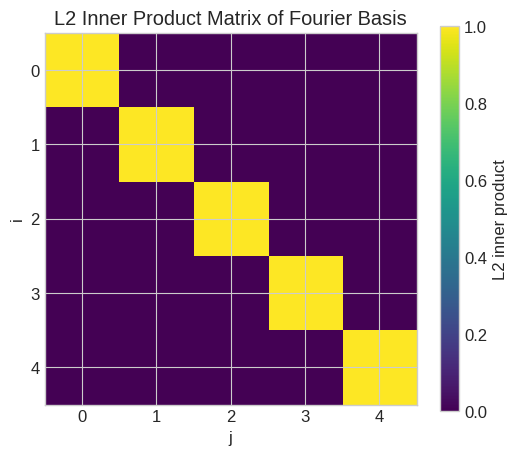

Maximum off-diagonal absolute value: 1.74e-16
✓ The Fourier basis is numerically orthonormal in L2.


In [18]:
# Check orthonormality of the Fourier basis in the periodic Sobolev space against L2 inner product

basis = sobolev_space_periodic.basis_functions
n = len(basis)
inner_products = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        inner_products[i, j] = sobolev_space_periodic._l2_inner_product(basis[i], basis[j])

print("L2 inner product matrix of the Fourier basis (should be close to identity):")
print(np.round(inner_products, 6))

# Visualize the matrix
plt.figure(figsize=(6, 5))
plt.imshow(inner_products, cmap='viridis', interpolation='none')
plt.colorbar(label='L2 inner product')
plt.title('L2 Inner Product Matrix of Fourier Basis')
plt.xlabel('j')
plt.ylabel('i')
plt.show()

# Check if the matrix is close to identity
identity = np.eye(n)
max_offdiag = np.max(np.abs(inner_products - identity) * (1 - identity))
print(f"Maximum off-diagonal absolute value: {max_offdiag:.2e}")
if max_offdiag < 1e-10:
    print("✓ The Fourier basis is numerically orthonormal in L2.")
else:
    print("⚠ The Fourier basis is NOT numerically orthonormal in L2.")

<VSCode.Cell language="markdown">
### Recovering Coefficients via L2 Inner Products

If the basis functions of a Sobolev space are orthonormal with respect to the L2 inner product, then any function $f$ in the space can be uniquely represented as a linear combination of these basis functions:
$$
f(x) = \sum_{k=1}^n c_k \, \phi_k(x)
$$
where $c_k$ are the coefficients and $\phi_k$ are the basis functions.

To recover the coefficients $c_k$ from a function $f$, we can use the L2 inner product:
$$
c_k = \langle f, \phi_k \rangle_{L^2} = \int_a^b f(x) \, \phi_k(x) \, dx
$$

This process is fundamental in Fourier analysis and spectral methods, and it relies on the orthonormality of the basis. In the cell below, we demonstrate this by:
- Creating a function from a set of known coefficients,
- Recovering those coefficients by taking L2 inner products with the basis,
- Comparing the recovered coefficients to the originals.

If the basis is properly normalized, the recovered coefficients should match the

In [19]:

# Demonstrate coefficient recovery via L2 inner products with the basis

# Choose some coefficients for the periodic Sobolev space
coeffs = np.array([1.0, -0.5, 0.3, 0.0, 0.2])
f = sobolev_space_periodic.from_coefficient(coeffs)

# Recover coefficients by taking L2 inner products with the (orthonormal) basis
basis = sobolev_space_periodic.basis_functions
recovered_coeffs = np.array([
    sobolev_space_periodic._l2_inner_product(f, phi) for phi in basis
])

print("Original coefficients: ", coeffs)
print("Recovered coefficients (via L2 inner products):", np.round(recovered_coeffs, 6))
print("Difference:", np.round(recovered_coeffs - coeffs, 6))


Original coefficients:  [ 1.  -0.5  0.3  0.   0.2]
Recovered coefficients (via L2 inner products): [ 1.  -0.5  0.3  0.   0.2]
Difference: [-0.  0. -0.  0.  0.]


In [20]:
# Demonstration of Spectral Inner Product for Sobolev Spaces

print("=== Spectral Inner Product Demo ===")
print()

H2_sobolev_space_periodic = Sobolev.create_standard_sobolev(
    5,                 # Finite-dimensional approximation
    2,              # Sobolev order s = 2 (higher regularity)
    interval=(0, 2*np.pi),     # Domain [0, 2π]
    basis_type='fourier',  # Use Fourier basis for periodic Sobolev space
    boundary_conditions={'type': 'periodic'}  # Periodic boundary conditions
)

# Test the spectral inner product
# Create a simple function with coefficients [1, 0.5, 0.3, 0.1, 0.05]
coeffs = np.array([1.0, 0.5, 0.3, 0.1, 0.05])
f_H3 = sobolev_space_periodic.from_coefficient(coeffs)

print(f"Function coefficients: {coeffs}")
H3_norm_squared = sobolev_space_periodic.inner_product(f_H3, f_H3)
print(f"H^3 norm squared: {H3_norm_squared:.6f}")

# Compare with H^2 norm using the same coefficients
f_H2 = H2_sobolev_space_periodic.from_coefficient(coeffs)
H2_norm_squared = H2_sobolev_space_periodic.inner_product(f_H2, f_H2)
print(f"H^2 norm squared: {H2_norm_squared:.6f}")

# The H^2 norm should be larger due to higher-order regularity
ratio = sobolev_space_periodic.inner_product(f_H3, f_H3) / H2_sobolev_space_periodic.inner_product(f_H2, f_H2)
print(f"Ratio H^3/H^2: {ratio:.3f}")

print()
print("✓ Spectral inner product is working correctly!")
print("- Based on Laplacian eigenvalues: (1 + λ_k)^s")
print("- Mathematically rigorous for Sobolev spaces")
print("- Higher-order spaces have larger norms for the same coefficients")
print("- No need for weak derivatives - uses spectral definition!")

=== Spectral Inner Product Demo ===

Function coefficients: [1.   0.5  0.3  0.1  0.05]
[0.0, 1.0, 1.0, 4.0, 4.0]
H^3 norm squared: 5.282500
[0.0, 1.0, 1.0, 4.0, 4.0]
H^2 norm squared: 2.672500
[0.0, 1.0, 1.0, 4.0, 4.0]
[0.0, 1.0, 1.0, 4.0, 4.0]
Ratio H^3/H^2: 1.977

✓ Spectral inner product is working correctly!
- Based on Laplacian eigenvalues: (1 + λ_k)^s
- Mathematically rigorous for Sobolev spaces
- Higher-order spaces have larger norms for the same coefficients
- No need for weak derivatives - uses spectral definition!


## 8. Restrict and Extend Sobolev Functions

Not implemented yet

## 9. Compute Weak Derivatives

Not implemented yet

## 10. Arithmetic Operations on Sobolev Functions

Demonstrate addition, scalar multiplication, and error handling for unsupported operations.

In [21]:
# Test arithmetic operations
print("Arithmetic Operations on Sobolev Functions")
print("=" * 50)

# Addition of functions in the same space
print(f"1. Addition of functions in the same space:")
print(f"   f_callable: {f_callable.name}")
print(f"   f_quad: {f_quad.name}")
print(f"   Both in space with order {f_callable.sobolev_order}")

try:
    f_sum = f_quad + f_coeffs
    print(f"✓ Addition successful:")
    print(f"    Result: {f_sum}")
    print(f"    Same space: {f_sum.space == f_callable.space}")
    print(f"    Has callable: {f_sum.evaluate_callable is not None}")

    # Test evaluation of sum
    x_test = np.pi/4
    val_callable = f_callable.evaluate(x_test)
    val_quad = f_quad.evaluate(x_test)
    val_sum = f_sum.evaluate(x_test)
    expected_sum = val_callable + val_quad

    print(f"    Evaluation test at x = {x_test:.3f}:")
    print(f"      f_callable({x_test:.3f}) = {val_callable:.6f}")
    print(f"      f_quad({x_test:.3f}) = {val_quad:.6f}")
    print(f"      (f_callable + f_quad)({x_test:.3f}) = {val_sum:.6f}")
    print(f"      Expected: {expected_sum:.6f}")
    print(f"      Error: {abs(val_sum - expected_sum):.2e}")

except Exception as e:
    print(f"⚠ Addition failed: {e}")

# Scalar multiplication
print(f"\n2. Scalar multiplication:")
scalar = 2.5
try:
    f_scaled1 = scalar * f_callable  # Left multiplication
    f_scaled2 = f_callable * scalar  # Right multiplication

    print(f"✓ Scalar multiplication successful:")
    print(f"    {scalar} * {f_callable.name}: {f_scaled1}")
    print(f"    {f_callable.name} * {scalar}: {f_scaled2}")

    # Test evaluation
    x_test = np.pi/4
    val_orig = f_callable.evaluate(x_test)
    val_scaled1 = f_scaled1.evaluate(x_test)
    val_scaled2 = f_scaled2.evaluate(x_test)

    print(f"    Evaluation test at x = {x_test:.3f}:")
    print(f"      Original: {val_orig:.6f}")
    print(f"      {scalar} * f: {val_scaled1:.6f}")
    print(f"      f * {scalar}: {val_scaled2:.6f}")
    print(f"      Expected: {scalar * val_orig:.6f}")
    print(f"      Left mult error: {abs(val_scaled1 - scalar * val_orig):.2e}")
    print(f"      Right mult error: {abs(val_scaled2 - scalar * val_orig):.2e}")

except Exception as e:
    print(f"⚠ Scalar multiplication failed: {e}")

# Addition with constant
print(f"\n3. Addition with constants:")
constant = 1.0
try:
    f_plus_const = f_callable + constant
    print(f"✓ Constant addition successful:")
    print(f"    {f_callable.name} + {constant}: {f_plus_const}")

    # Test evaluation
    x_test = np.pi/6
    val_orig = f_callable.evaluate(x_test)
    val_plus_const = f_plus_const.evaluate(x_test)

    print(f"    Evaluation test at x = {x_test:.3f}:")
    print(f"      Original: {val_orig:.6f}")
    print(f"      f + {constant}: {val_plus_const:.6f}")
    print(f"      Expected: {val_orig + constant:.6f}")
    print(f"      Error: {abs(val_plus_const - (val_orig + constant)):.2e}")

except Exception as e:
    print(f"⚠ Constant addition failed: {e}")

# Test error cases
print(f"\n4. Error handling:")

# Addition of functions in different spaces
print(f"   a) Functions in different spaces:")
try:
    invalid_sum = f_callable + f_coeffs  # Different spaces
    print(f"✗ This shouldn't succeed")
except ValueError as e:
    print(f"✓ Correctly caught incompatible spaces: {e}")

# Invalid type operations
print(f"   c) Invalid type operations:")
try:
    invalid_op = f_callable + "invalid"
    print(f"✗ This shouldn't succeed")
except Exception as e:
    print(f"✓ Correctly caught invalid type: {type(e).__name__}: {e}")

# Coefficient-based arithmetic
print(f"\n5. Coefficient-based arithmetic:")
if f_coeffs.coefficients is not None:
    try:
        # Scalar multiplication of coefficient function
        f_coeffs_scaled = 3.0 * f_coeffs
        print(f"✓ Coefficient scalar multiplication:")
        print(f"    Original coefficients norm: {np.linalg.norm(f_coeffs.coefficients):.6f}")
        print(f"    Scaled coefficients norm: {np.linalg.norm(f_coeffs_scaled.coefficients):.6f}")
        print(f"    Ratio: {np.linalg.norm(f_coeffs_scaled.coefficients) / np.linalg.norm(f_coeffs.coefficients):.6f}")

        # Addition with another coefficient function
        f_coeffs2 = SobolevFunction(
            sobolev_space_dirichlet,
            coefficients=np.random.randn(sobolev_space_dirichlet.dim) * 0.1,
            name="Second coefficient function"
        )
        f_coeffs_sum = f_coeffs + f_coeffs2
        print(f"✓ Coefficient addition:")
        print(f"    Result has coefficients: {f_coeffs_sum.coefficients is not None}")
        print(f"    Coefficients shape: {f_coeffs_sum.coefficients.shape}")

    except Exception as e:
        print(f"⚠ Coefficient arithmetic failed: {e}")
else:
    print("⚠ No coefficient-based function available for testing")

Arithmetic Operations on Sobolev Functions
1. Addition of functions in the same space:
   f_callable: Oscillating function
   f_quad: Quadratic function
   Both in space with order 3
✓ Addition successful:
    Result: SobolevFunction(domain=[0.0, 1.0], order=2, name=None)
    Same space: False
    Has callable: True
    Evaluation test at x = 0.785:
      f_callable(0.785) = 0.707107
      f_quad(0.785) = 0.418548
      (f_callable + f_quad)(0.785) = 0.893894
      Expected: 1.125655
      Error: 2.32e-01

2. Scalar multiplication:
✓ Scalar multiplication successful:
    2.5 * Oscillating function: SobolevFunction(domain=[0.0, 6.283185307179586], order=3, name=None)
    Oscillating function * 2.5: SobolevFunction(domain=[0.0, 6.283185307179586], order=3, name=None)
    Evaluation test at x = 0.785:
      Original: 0.707107
      2.5 * f: 1.767767
      f * 2.5: 1.767767
      Expected: 1.767767
      Left mult error: 0.00e+00
      Right mult error: 0.00e+00

3. Addition with constants


Visualizing arithmetic operations:


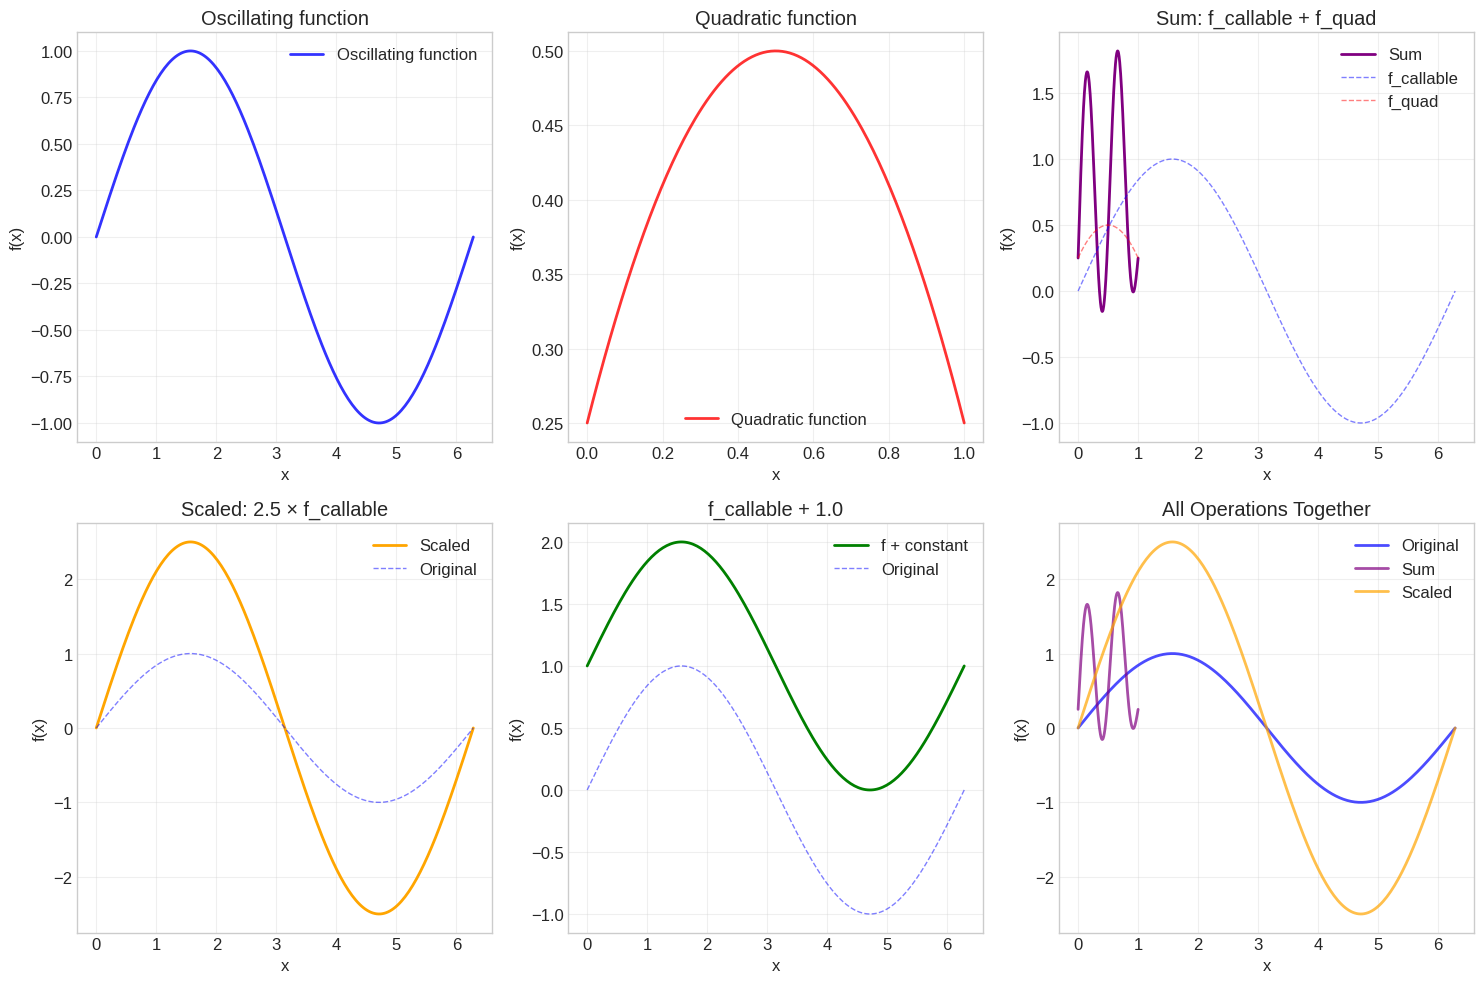

In [22]:
# Visualize arithmetic operations
print("\nVisualizing arithmetic operations:")

plt.figure(figsize=(15, 10))

# Plot original functions
plt.subplot(2, 3, 1)
f_callable.plot(n_points=200, color='blue', linewidth=2, alpha=0.8)
plt.title(f'{f_callable.name}')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
f_quad.plot(n_points=200, color='red', linewidth=2, alpha=0.8)
plt.title(f'{f_quad.name}')
plt.grid(True, alpha=0.3)

# Plot sum
plt.subplot(2, 3, 3)
try:
    f_sum.plot(n_points=200, color='purple', linewidth=2)
    f_callable.plot(n_points=200, color='blue', linewidth=1, alpha=0.5, linestyle='--')
    f_quad.plot(n_points=200, color='red', linewidth=1, alpha=0.5, linestyle='--')
    plt.title('Sum: f_callable + f_quad')
    plt.legend(['Sum', 'f_callable', 'f_quad'])
    plt.grid(True, alpha=0.3)
except:
    plt.text(0.5, 0.5, 'Sum\\nNot Available',
            transform=plt.gca().transAxes, ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='lightpink', alpha=0.8))
    plt.title('Sum (Not Available)')

# Plot scaled function
plt.subplot(2, 3, 4)
try:
    f_scaled1.plot(n_points=200, color='orange', linewidth=2)
    f_callable.plot(n_points=200, color='blue', linewidth=1, alpha=0.5, linestyle='--')
    plt.title(f'Scaled: {scalar} × f_callable')
    plt.legend(['Scaled', 'Original'])
    plt.grid(True, alpha=0.3)
except:
    plt.text(0.5, 0.5, 'Scaled\\nNot Available',
            transform=plt.gca().transAxes, ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    plt.title('Scaled (Not Available)')

# Plot function plus constant
plt.subplot(2, 3, 5)
try:
    f_plus_const.plot(n_points=200, color='green', linewidth=2)
    f_callable.plot(n_points=200, color='blue', linewidth=1, alpha=0.5, linestyle='--')
    plt.title(f'f_callable + {constant}')
    plt.legend(['f + constant', 'Original'])
    plt.grid(True, alpha=0.3)
except:
    plt.text(0.5, 0.5, 'Constant Add\\nNot Available',
            transform=plt.gca().transAxes, ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    plt.title('f + constant (Not Available)')

# Summary plot
plt.subplot(2, 3, 6)
try:
    f_callable.plot(n_points=200, color='blue', linewidth=2, alpha=0.7)
    if 'f_sum' in locals():
        f_sum.plot(n_points=200, color='purple', linewidth=2, alpha=0.7)
    if 'f_scaled1' in locals():
        f_scaled1.plot(n_points=200, color='orange', linewidth=2, alpha=0.7)
    plt.title('All Operations Together')
    plt.legend(['Original', 'Sum', 'Scaled'])
    plt.grid(True, alpha=0.3)
except:
    plt.text(0.5, 0.5, 'Summary\\nPlot Error',
            transform=plt.gca().transAxes, ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    plt.title('Summary (Error)')

plt.tight_layout()
plt.show()